<h1> Desafió Spike </h1>
<p> <b> Objetivo desafío: </b> Ser capaces de predecir el precio de un insumo básico, como la leche, a partir de variables climatológicas y macroeconómicas. </p>

Índice:
1. Análisis exploratorio.
    1.1 Lectura y visualización de archivo "precipitaciones.csv"
    1.2

In [1]:
#from matplotlib.gridspec import GridSpec
#import itertools
#from functools import reduce

In [2]:
#import sys
#sys.path.insert(0, 'Script')
#from plot_functions import k_bins, plot_distribution, plot_allboxplot, plotSTPrecipitación,plotSTBancoCentral, plotSTbyYearPrecipitación
#from plot_functions import plot_variablesrelevantes

<h2> 1. Análisis exploratorio </h2>
<h3> 1.1 Lectura de los archivos: precipitaciones.csv, banco_central, precio_leche </h3>

In [3]:
import pandas as pd
import numpy as np
import os
import math
from IPython.display import display

import sys
sys.path.insert(0, 'Script')
from reconstruccion_series import SeriesBC_IMACEC, SeriesBC_PIB, SeriesBC_Precio, SeriesBC_Ocupacion, SeriesBC_TCMTCR, SeriesBC_Produccion, SeriesBc_Ventas

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

def reading_csv(path, date_column, date_format, dtype=None, create_date=False):
    df = pd.read_csv(path, dtype=dtype)
    if create_date:
        meses_es    = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
        meses_en    = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        to_meses    = {mes_es: mes_en for mes_es, mes_en in zip(meses_es, meses_en)}
        df["Mes"]   = df["Mes"].map(to_meses).astype(str)
        df["Anio"]  = df["Anio"].astype(str)
        df[date_column] = df.apply(lambda x: x["Anio"]+"-"+x["Mes"], axis=1)
    df[date_column] = pd.to_datetime(df[date_column], errors="coerce", format=date_format)
    #df.set_index(date_column, inplace=True)
    df.sort_values(date_column, inplace=True)
    return df

def drop_missing(df, date_column=None):
    # NaN values
    nan_values  = df.isna().sum().sum()
    # Duplicated
    if nan_values == 0 and df.duplicated().any()==False:
        print(f"NaN values: {nan_values}")
    else:
        print(f"NaN values: {nan_values}")
        display(df[df[date_column].duplicated(keep=False)])
        df = df.apply(lambda x: x.replace("a", np.nan, regex=True), axis=1)
        df = df.drop_duplicates(subset=date_column).dropna(subset=[date_column])
    return df

def return_statical_summary_and_save(df, percentiles, path_output_resume, path_output_file):
    print(df.info())
    df.describe(percentiles = percentiles).T.to_csv(path_output_resume)
    with pd.option_context('display.float_format', '{:0.2f}'.format):
        display(df.describe(percentiles = percentiles).T)
    df.to_csv(path_output_file)
    return df

def set_index_column(df, col_name):
    return df.set_index(col_name)

def rename_index(df, old_name, new_name):
    df.rename(columns={old_name: new_name}, inplace=True)
    return df

In [4]:
%%time

df_prec = reading_csv(
    path         = "Data\precipitaciones.csv",
    date_column  = "date",
    date_format  = "%Y-%m-%d"
)

df_prec_cleaned = (
    df_prec.pipe(drop_missing)
        .pipe(set_index_column, "date")
        .pipe(return_statical_summary_and_save, [.05, .25, .5, .75, .95], 'Output/Data/resumen_descriptivo_precipitacion.csv', 'Output/Data/precipitaciones_cleaned.csv')
 )

NaN values: 0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 496 entries, 1979-01-01 to 2020-04-01
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Coquimbo                             496 non-null    float64
 1   Valparaiso                           496 non-null    float64
 2   Metropolitana_de_Santiago            496 non-null    float64
 3   Libertador_Gral__Bernardo_O_Higgins  496 non-null    float64
 4   Maule                                496 non-null    float64
 5   Biobio                               496 non-null    float64
 6   La_Araucania                         496 non-null    float64
 7   Los_Rios                             496 non-null    float64
dtypes: float64(8)
memory usage: 34.9 KB
None


,count,mean,std,min,5%,25%,50%,75%,95%,max
Coquimbo,496.00,16.15,32.63,0.00,0.06,0.82,4.07,16.14,68.24,347.13
Valparaiso,496.00,32.45,55.43,0.00,0.04,1.54,9.04,38.41,127.95,441.05
Metropolitana_de_Santiago,496.00,49.67,74.36,0.00,0.21,5.30,19.09,63.41,186.65,524.59
Libertador_Gral__Bernardo_O_Higgins,496.00,72.25,101.43,0.00,0.08,5.34,26.00,101.88,275.72,645.52
Maule,496.00,98.66,122.77,0.00,0.74,11.90,45.65,142.23,353.42,759.18
Biobio,496.00,128.11,130.06,0.00,5.20,29.36,79.56,184.75,403.14,702.43
La_Araucania,496.00,151.49,126.63,0.01,16.27,52.93,110.57,208.32,404.18,661.21
Los_Rios,496.00,199.45,140.07,0.75,37.34,89.81,159.47,274.59,475.62,717.74


Wall time: 110 ms


In [5]:
%%time

df_bc = reading_csv(
    path         = "Data/banco_central.csv",
    date_column  = "Periodo",
    date_format  = "%Y-%m-%d %H:%M:%S UTC",
    dtype        = object
)

df_bc_cleaned = (
    df_bc.pipe(drop_missing, date_column="Periodo")
        .pipe(rename_index, "Periodo", "date")
        .pipe(set_index_column, "date")
        .pipe(SeriesBC_IMACEC)
        .pipe(SeriesBC_PIB)
        .pipe(SeriesBC_Precio)
        .pipe(SeriesBC_Ocupacion)
        .pipe(SeriesBC_TCMTCR)
        .pipe(SeriesBC_Produccion)
        .pipe(SeriesBc_Ventas)
        .pipe(return_statical_summary_and_save, [.05, .25, .5, .75, .95], 'Output/Data/resumen_descriptivo_banco_central.csv', 'Output/Data/banco_central_cleaned.csv')
)

NaN values: 37102


,Periodo,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,...,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
65,2018-08-01,109.690.834,994.693.267,101.027.633,1.051.861,931.900.957,106.248.833,117.404.143,109.458.386,110.578.221,...,911.086.301,102.691.109,983.228.221,108.792.744,105.596.535,654.060.172,113.525.936,103.995.337,15.375.472,38729
66,2018-08-01,109.690.834,994.693.267,101.027.633,1.051.861,931.900.957,106.248.833,117.404.143,109.458.386,110.578.221,...,911.086.301,102.691.109,983.228.221,108.792.744,105.596.535,654.060.172,113.525.936,103.995.337,15.375.472,38729
78,2019-08-01,113.886.371,103.237.519,106.828.407,105.153.122,984.395.274,106.901.816,122.596.004,113.695.907,114.580.893,...,948.715.254,104.034.103,102.619.922,107.666.732,104.591.452,6598,116.203.109,107.385.297,15.342.321,33059
79,2019-08-01,113.886.371,103.237.519,106.828.407,105.153.122,984.395.274,106.901.816,122.596.004,113.695.907,114.580.893,...,948.715.254,104.034.103,102.619.922,107.666.732,104.591.452,6598,116.203.109,107.385.297,15.342.321,33059


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 611 entries, 1970-01-01 to 2020-11-01
Data columns (total 84 columns):
 #   Column                                                                              Non-Null Count  Dtype  
---  ------                                                                              --------------  -----  
 0   Imacec_empalmado                                                                    298 non-null    float32
 1   Imacec_produccion_de_bienes                                                         298 non-null    float32
 2   Imacec_minero                                                                       298 non-null    float32
 3   Imacec_industria                                                                    298 non-null    float32
 4   Imacec_resto_de_bienes                                                              298 non-null    float32
 5   Imacec_comercio                                                                 

,count,mean,std,min,5%,25%,50%,75%,95%,max
Imacec_empalmado,298.00,80.90,21.26,45.35,50.58,60.15,80.33,100.67,113.26,122.35
Imacec_produccion_de_bienes,298.00,87.66,13.77,57.29,66.10,76.49,87.90,98.30,109.07,123.73
Imacec_minero,298.00,93.51,10.35,58.15,70.86,88.26,95.40,100.54,107.33,113.63
Imacec_industria,298.00,86.76,13.24,58.37,66.94,74.75,87.99,98.00,105.93,112.46
Imacec_resto_de_bienes,298.00,82.00,22.06,44.07,50.86,64.07,80.00,96.55,121.99,141.50
...,...,...,...,...,...,...,...,...,...,...
Generacion_de_energia_electrica_CDEC_GWh,262.00,4909.36,1110.49,2724.40,3119.99,4029.29,4817.86,5936.56,6533.85,6798.20
Indice_de_ventas_comercio_real_IVCM,82.00,106.99,13.02,75.73,91.27,99.91,104.09,111.01,134.75,150.15
Indice_de_ventas_comercio_real_no_durables_IVCM,82.00,103.96,11.19,76.34,92.88,99.51,102.01,105.48,133.12,142.73
Indice_de_ventas_comercio_real_durables_IVCM,82.00,119.77,24.62,73.19,87.63,99.84,115.45,136.14,164.94,181.49


Wall time: 2 s


In [6]:
%%time

df_leche = reading_csv(
    path         = "Data/precio_leche.csv",
    date_column  = "date",
    date_format  = "%Y-%b",
    create_date  = True

)

df_leche_cleaned = (
    df_leche.pipe(drop_missing)
        .pipe(set_index_column, "date")
        .pipe(return_statical_summary_and_save, [.05, .25, .5, .75, .95], 'Output/Data/resumen_descriptivo_precio_leche.csv', 'Output/Data/precio_leche_cleaned.csv')
)

NaN values: 0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 506 entries, 1979-01-01 to 2021-02-01
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Anio          506 non-null    object 
 1   Mes           506 non-null    object 
 2   Precio_leche  506 non-null    float64
dtypes: float64(1), object(2)
memory usage: 15.8+ KB
None


,count,mean,std,min,5%,25%,50%,75%,95%,max
Precio_leche,506.00,114.44,79.00,3.85,7.26,48.16,102.25,189.18,241.06,318.88


Wall time: 128 ms


<h3> 1.2 Visualización previa de las distribución de cada uno </h3>

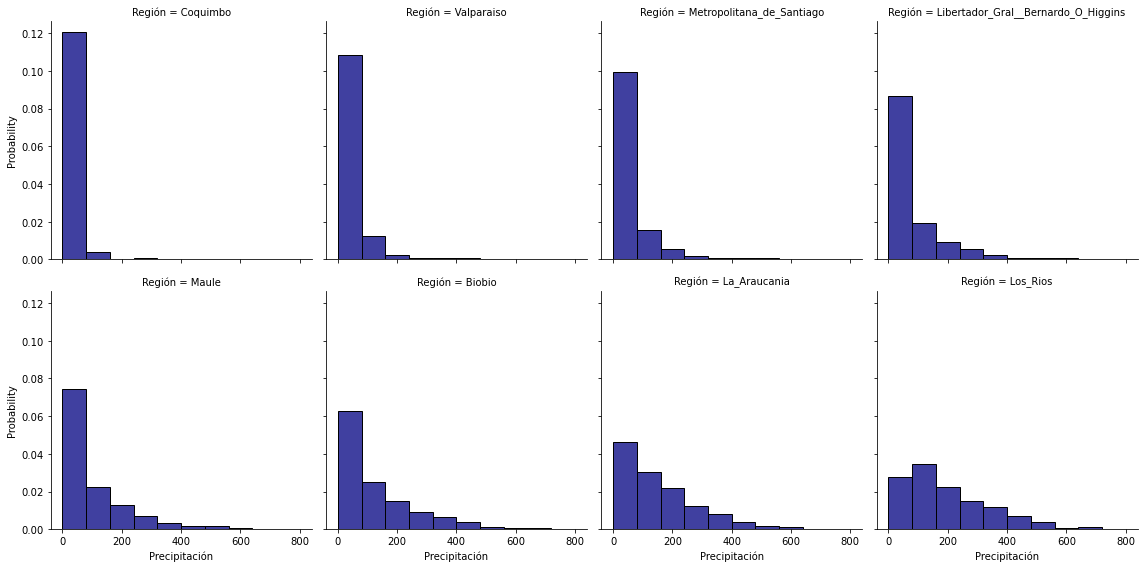

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def k_bins(n):
    """
    Función para determinar número de bins en un histograma

    n (float, int) : Largo de un dataframes o una serie de datos.
    """
    if n >= 100:
        return np.round(1+ 3.322*np.log10(n)).astype(int)
    else:
        return np.round(np.sqrt(n)).astype(int)

_ = sns.displot(
    data        = df_prec_cleaned.stack().reset_index().rename({"level_1": "Región", 0:"Precipitación"}, axis=1),
    x           = "Precipitación",
    col         = "Región",
    kind        = "hist",
    col_wrap    = 4,
    bins        = k_bins(len(df_prec_cleaned)),
    binrange    = (0, 800),
    color       = "navy",
    stat        = "probability",
    height      = 4,
    facet_kws   = dict(margin_titles=True)
)

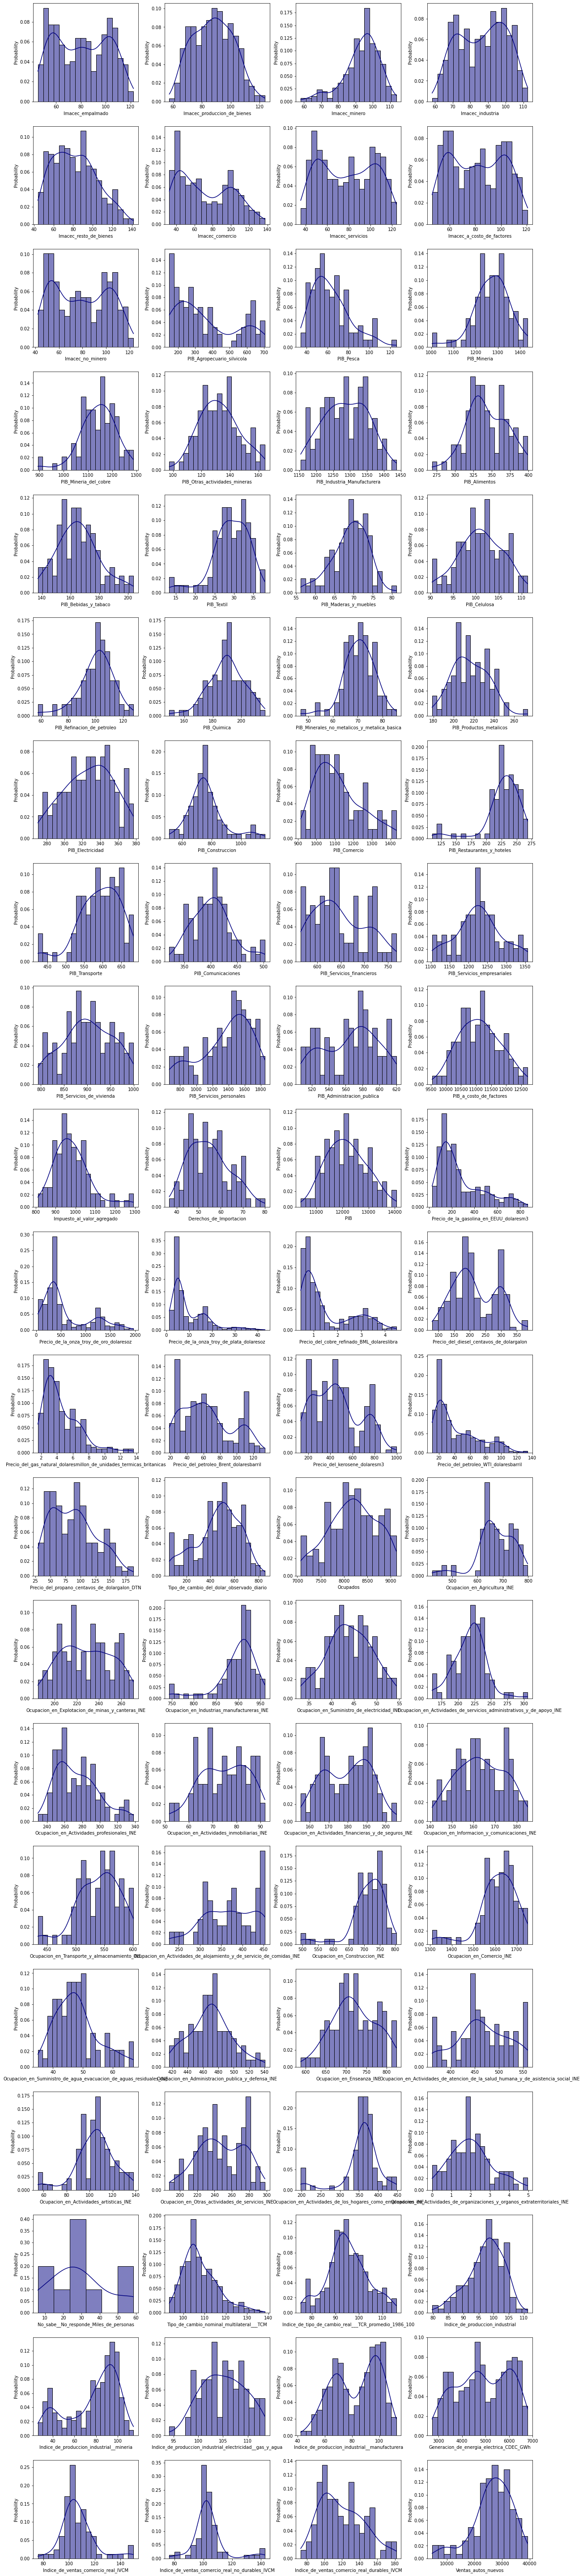

In [38]:
fig, axes = plt.subplots(
    ncols = 4, nrows = int(df_bc_cleaned.shape[1] / 4),
    figsize = (20, 5 * int(df_bc_cleaned.shape[1] / 4)),
    gridspec_kw = {"wspace": 0.25, "hspace": 0.25}
)
n = 0
for ax in axes.flatten():
    col_name = df_bc_cleaned.columns[n]
    _ = sns.histplot(
        data    = df_bc_cleaned,
        x       = col_name,
        color   = "navy",
        stat    = "probability",
        bins    = 2*k_bins(df_bc_cleaned[col_name].count()),
        kde     = True,
        ax      = ax
    )
    n += 1

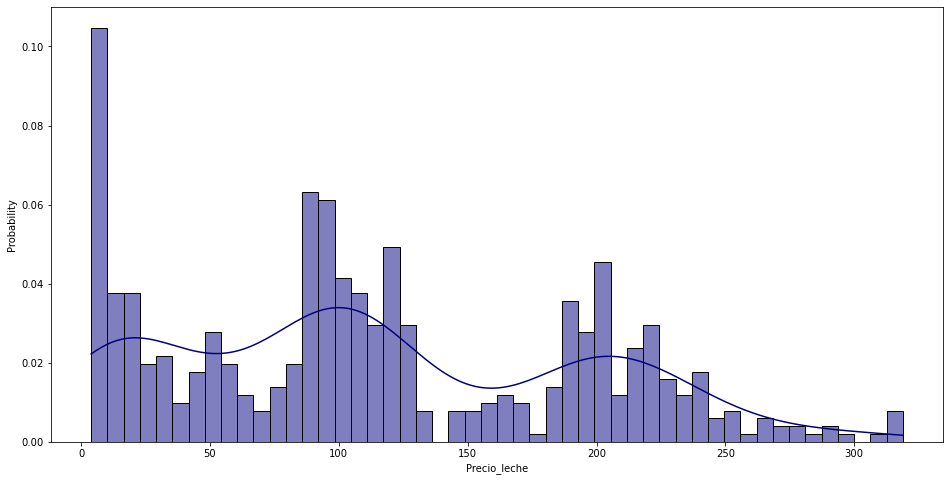

In [36]:
fig, ax = plt.subplots(figsize = (16, 8))

_ = sns.histplot(
    data    = df_leche_cleaned,
    x       = "Precio_leche",
    color   = "navy",
    stat    = "probability",
    bins    = 5*k_bins(df_leche_cleaned["Precio_leche"].count()),
    kde     = True,
    ax      = ax
)

## 2.3 Análisis y comentarios de ambos archivos:

De acuerdo a lo observado anteriormente:
* Respecto a los registros duplicados y nulos en cada archivo:
    1. No hay registros de precipitación duplicados y ni datos anómalos, teniendo 496 observaciones para cada región en el archivo "precipitaciones.csv".
    2. En el archivo "banco_central.csv" existen dos fechas con archivos duplicados: "2018-08-01" y "2019-08-01". También existen registros con letra "a", lo que no es considerado como un valor nulo, por lo tanto se hace una limpieza de los datos duplicados y aquellos con valores como "a" son pasados a un valor NaN.
    3. Además, las diferentes variables económicas presentan registros en periodos, lo que genera datos nulos.
* Respecto al análisis descriptivo, histogramas y boxplot para el archivo "precipitaciones" se tiene:
    1. Desde la región más al norte (Coquimbo) hasta la región más al sur (Los Rios), se observa en los percentiles 25, 50 y 75, junto a la media un aumento en intensidad de la precipitación registrada. Misma tendencia no es compartida en los valores máximos.
    2.

# 3. Visualización de datos.
## 3.1 función para gráficar series históricas de precipitaciones para un rango de fecha determinado

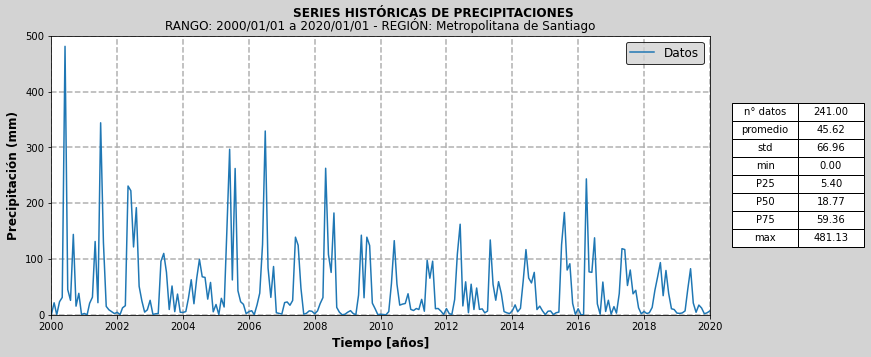

In [13]:
plotSTPrecipitación(precipitaciones, 'Metropolitana', "2000-01-01", "2020-01-01")

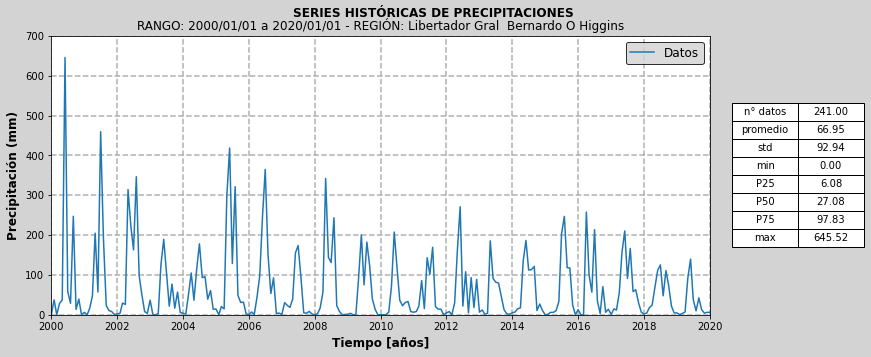

In [14]:
plotSTPrecipitación(precipitaciones, 'Libertador', "2000-01-01", "2020-01-01")

In [15]:
plotSTPrecipitación(precipitaciones, 'ADFAXC', "2000-01-01", "2020-01-01")

Error: No se encuentra la región: ADFAXC dentro del archivo.


Respecto a estas series históricas para la precipitación en ambas regiones se presenta estacionalmente una precipitación máxima en los meses de invierno (Junio, Julio y Agosto), mientras que en los meses de verano (Diciembre, Enero y Febrero) se observan los valores mínimos año a año. Frente a las tendencias, se observa una menor precipitación a lo largo del rango temporal, es decir, ha disminuido la precipitación desde el año 2000 al año 2020.

## 3.2 función para gráficar series históricas de precipitaciones para una lista de años

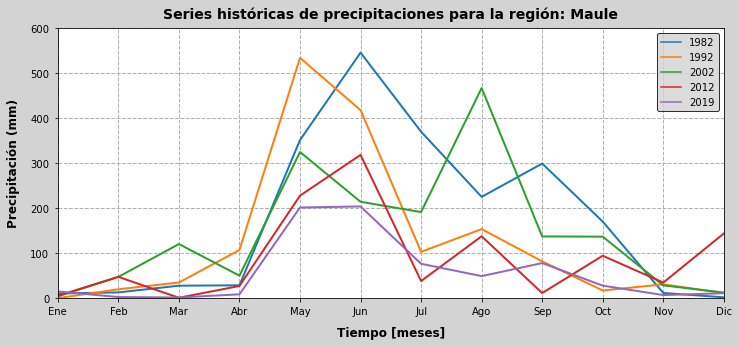

In [16]:
plotSTbyYearPrecipitación(precipitaciones, 'Maule', [1982, 1992, 2002, 2012, 2019])

In [17]:
precipitaciones.loc[precipitaciones.index.year.isin([1982, 1992, 2002, 2012, 2019]), "Maule"].groupby(pd.Grouper(freq="Y", origin='start')).describe().dropna()

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
1982-12-31,12.000,171.486,185.239,2.219,12.810,99.707,312.531,545.903
1992-12-31,12.000,126.192,171.857,0.324,19.380,58.578,118.999,534.356
2002-12-31,12.000,144.780,139.245,4.371,42.896,128.779,197.328,467.313
2012-12-31,12.000,90.828,99.610,1.185,23.470,42.976,139.406,318.641
2019-12-31,12.000,57.114,73.204,1.780,8.451,21.646,77.099,204.119


Para los diferentes años, los meses de verano (Diciembre, Enero y Febrero) presentan una menor precipitación, mientras que los máximos observados se encuentran entre los meses de Mayo a Agosto. En especifico, en el mes de Mayo se observa el máximo para el año 1992, en el mes de Junio se observa una precipitación máxima para los año 1982, 2012 y 2019, en el mes de Agosto se observa una precipitación máxima para el año 2002. Además, de este gráfico se determina que en los últimos años una disminución de la precipitación registrada a lo largo del año.

## 3.3 función para gráficar series históricas de variables economicas para un rango temporal.

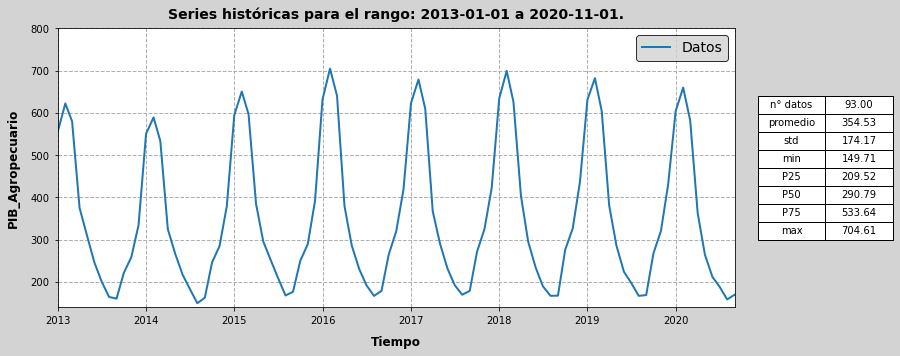

In [18]:
plotSTBancoCentral(bc, "PIB_Agropecuario", "2013-01-01", '2020-11-01')

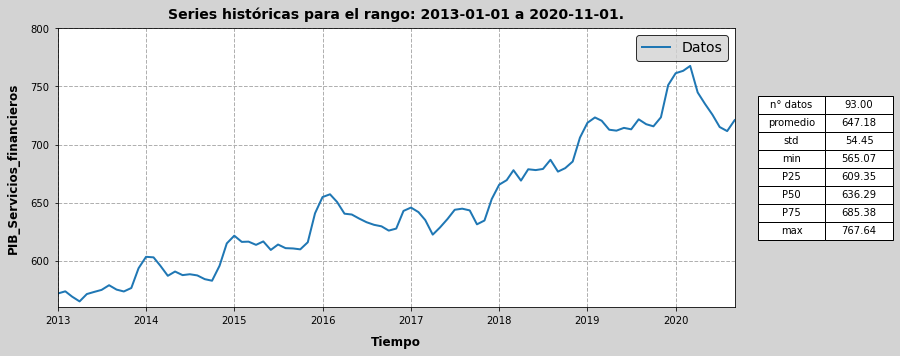

In [19]:
plotSTBancoCentral(bc, "PIB_Servicios_financieros", "2013-01-01", '2020-11-01')

In [20]:
condicion = (bc.index >= "2013-01-01") & (bc.index <= '2020-11-01')
display(bc.loc[condicion, ['PIB_Agropecuario_silvicola', 'PIB_Servicios_financieros']].describe().T)
print("Coeficiente de Pearson: {:.3f} (-)".format(bc.loc[condicion, ['PIB_Agropecuario_silvicola', 'PIB_Servicios_financieros']].corr(method="pearson").to_numpy()[0,1]))

,count,mean,std,min,25%,50%,75%,max
PIB_Agropecuario_silvicola,93.000,354.526,174.174,149.713,209.516,290.787,533.637,704.614
PIB_Servicios_financieros,93.000,647.183,54.450,565.071,609.352,636.286,685.385,767.636


Coeficiente de Pearson: 0.135 (-)


El PIB agropecuario presenta una estacionalidad con ingresos máximos en los meses de verano, y mínimos en los meses de invierno. A lo largo de los años los máximos y mínimos presentan valores parecidos año a año.

El PIB de servicios financiero no presenta una estacionalidad anual, pero si presenta una tendencia creciente desde el año 2013 al año 2020. En este último se observa un decrecimiento debido a la pandemia por el SAR-Cov-2.

Finalmente, ambas no estan relacionadas. Esto debido al comportamiento de cada una de las series de tiempo y los parámetros estadisticos como el promedio, desviación estandar, mínimo, máximo y los percentiles 25, 50 y 75. Además, el coefiente de correlación lineal demuestra que ambas variables economicas no están suficientemente relacionadas entre si por presentar un valor cercano a 0.

# 4. Tratamiento y creación de variables
## 4.1 ¿Cómo podríamos evaluar la correlación entre las distintas series de tiempo y cómo se tienen que correlacionar para entrenar un modelo? ¿Mucha correlación, no correlacionadas, da igual?

## 4.2 Lectura archivo "precio_leche.csv" y merge con las bases de datos de precipitaciones y datos del Banco Central

In [21]:
precio_leche = pd.read_csv("Data/precio_leche.csv")

None if (precio_leche.index.name == "date") else precio_leche.set_index("date", inplace=True)
precio_leche.drop(["Anio","Mes"], axis=1, inplace=True)
display(precio_leche.head())
display(precio_leche.info())

,Precio_leche
date,
1979-01-01,3.850
1979-02-01,4.580
1979-03-01,5.180
1979-04-01,6.060
1979-05-01,7.250


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 506 entries, 1979-01-01 to 2021-02-01
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Precio_leche  506 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


None

In [22]:
bc.index.rename("date", inplace=True)
df_merge = reduce(lambda left,right: pd.merge(left,right,on='date', how="left"), [precio_leche, precipitaciones, bc])
print(df_merge.shape)
df_merge.head()

(506, 93)


,Precio_leche,Coquimbo,Valparaiso,Metropolitana_de_Santiago,Libertador_Gral__Bernardo_O_Higgins,Maule,Biobio,La_Araucania,Los_Rios,Imacec_empalmado,Imacec_produccion_de_bienes,Imacec_minero,Imacec_industria,Imacec_resto_de_bienes,Imacec_comercio,Imacec_servicios,Imacec_a_costo_de_factores,Imacec_no_minero,PIB_Agropecuario_silvicola,PIB_Pesca,PIB_Mineria,PIB_Mineria_del_cobre,PIB_Otras_actividades_mineras,PIB_Industria_Manufacturera,PIB_Alimentos,PIB_Bebidas_y_tabaco,PIB_Textil,PIB_Maderas_y_muebles,PIB_Celulosa,PIB_Refinacion_de_petroleo,PIB_Quimica,PIB_Minerales_no_metalicos_y_metalica_basica,PIB_Productos_metalicos,PIB_Electricidad,PIB_Construccion,PIB_Comercio,PIB_Restaurantes_y_hoteles,PIB_Transporte,PIB_Comunicaciones,PIB_Servicios_financieros,PIB_Servicios_empresariales,PIB_Servicios_de_vivienda,PIB_Servicios_personales,PIB_Administracion_publica,PIB_a_costo_de_factores,Impuesto_al_valor_agregado,Derechos_de_Importacion,PIB,Precio_de_la_gasolina_en_EEUU_dolaresm3,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_cobre_refinado_BML_dolareslibra,Precio_del_diesel_centavos_de_dolargalon,Precio_del_gas_natural_dolaresmillon_de_unidades_termicas_britanicas,Precio_del_petroleo_Brent_dolaresbarril,Precio_del_kerosene_dolaresm3,Precio_del_petroleo_WTI_dolaresbarril,Precio_del_propano_centavos_de_dolargalon_DTN,Tipo_de_cambio_del_dolar_observado_diario,Ocupados,Ocupacion_en_Agricultura_INE,Ocupacion_en_Explotacion_de_minas_y_canteras_INE,Ocupacion_en_Industrias_manufactureras_INE,Ocupacion_en_Suministro_de_electricidad_INE,Ocupacion_en_Actividades_de_servicios_administrativos_y_de_apoyo_INE,Ocupacion_en_Actividades_profesionales_INE,Ocupacion_en_Actividades_inmobiliarias_INE,Ocupacion_en_Actividades_financieras_y_de_seguros_INE,Ocupacion_en_Informacion_y_comunicaciones_INE,Ocupacion_en_Transporte_y_almacenamiento_INE,Ocupacion_en_Actividades_de_alojamiento_y_de_servicio_de_comidas_INE,Ocupacion_en_Construccion_INE,Ocupacion_en_Comercio_INE,Ocupacion_en_Suministro_de_agua_evacuacion_de_aguas_residuales_INE,Ocupacion_en_Administracion_publica_y_defensa_INE,Ocupacion_en_Enseanza_INE,Ocupacion_en_Actividades_de_atencion_de_la_salud_humana_y_de_asistencia_social_INE,Ocupacion_en_Actividades_artisticas_INE,Ocupacion_en_Otras_actividades_de_servicios_INE,Ocupacion_en_Actividades_de_los_hogares_como_empleadores_INE,Ocupacion_en_Actividades_de_organizaciones_y_organos_extraterritoriales_INE,No_sabe__No_responde_Miles_de_personas,Tipo_de_cambio_nominal_multilateral___TCM,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_produccion_industrial,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_produccion_industrial__manufacturera,Generacion_de_energia_electrica_CDEC_GWh,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Ventas_autos_nuevos
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1979-01-01,3.850,2.642,0.587,2.447,1.609,3.736,17.860,25.213,45.596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.720,227.270,6.260,0.752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-02-01,4.580,1.180,2.432,3.998,4.346,16.348,17.681,18.085,34.075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167.130,245.670,7.420,0.882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-03-01,5.180,0.255,0.021,0.000,0.055,0.545,14.436,28.697,66.232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

## 4.3 Crea las variables:

* A partir de la variable fecha, crea nuevas variables para el año, mes, trimestre.
* Lags y estadísticas acumuladas (por ejemplo: promedio, varianza) de las variables que consideres relevantes.

In [23]:
condicion    = (df_merge.corr()['Precio_leche'] >= 0.75) | (df_merge.corr()['Precio_leche'] <= -0.75)
columnas_relevantes = condicion.where(condicion==True).dropna().index
df_merge[columnas_relevantes].corr()['Precio_leche'].sort_values()

Indice_de_produccion_industrial__mineria         0.792
Precio_del_cobre_refinado_BML_dolareslibra       0.801
Imacec_produccion_de_bienes                      0.812
Tipo_de_cambio_del_dolar_observado_diario        0.813
Precio_de_la_onza_troy_de_oro_dolaresoz          0.824
Imacec_industria                                 0.874
Indice_de_produccion_industrial__manufacturera   0.875
Imacec_comercio                                  0.878
Imacec_a_costo_de_factores                       0.904
Imacec_empalmado                                 0.905
Imacec_no_minero                                 0.909
Generacion_de_energia_electrica_CDEC_GWh         0.914
Imacec_servicios                                 0.918
Precio_leche                                     1.000
Name: Precio_leche, dtype: float64

In [24]:
import ppscore as pps

pps_matrix = pps.matrix(df_merge, cross_validation=10)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
pps_matrix.head()

x,Biobio,Coquimbo,Derechos_de_Importacion,Generacion_de_energia_electrica_CDEC_GWh,Imacec_a_costo_de_factores,Imacec_comercio,Imacec_empalmado,Imacec_industria,Imacec_minero,Imacec_no_minero,Imacec_produccion_de_bienes,Imacec_resto_de_bienes,Imacec_servicios,Impuesto_al_valor_agregado,Indice_de_produccion_industrial,Indice_de_produccion_industrial__manufacturera,Indice_de_produccion_industrial__mineria,Indice_de_produccion_industrial_electricidad__gas_y_agua,Indice_de_tipo_de_cambio_real___TCR_promedio_1986_100,Indice_de_ventas_comercio_real_IVCM,Indice_de_ventas_comercio_real_durables_IVCM,Indice_de_ventas_comercio_real_no_durables_IVCM,La_Araucania,Libertador_Gral__Bernardo_O_Higgins,Los_Rios,Maule,Metropolitana_de_Santiago,No_sabe__No_responde_Miles_de_personas,Ocupacion_en_Actividades_artisticas_INE,Ocupacion_en_Actividades_de_alojamiento_y_de_servicio_de_comidas_INE,Ocupacion_en_Actividades_de_atencion_de_la_salud_humana_y_de_asistencia_social_INE,Ocupacion_en_Actividades_de_los_hogares_como_empleadores_INE,Ocupacion_en_Actividades_de_organizaciones_y_organos_extraterritoriales_INE,Ocupacion_en_Actividades_de_servicios_administrativos_y_de_apoyo_INE,Ocupacion_en_Actividades_financieras_y_de_seguros_INE,Ocupacion_en_Actividades_inmobiliarias_INE,Ocupacion_en_Actividades_profesionales_INE,Ocupacion_en_Administracion_publica_y_defensa_INE,Ocupacion_en_Agricultura_INE,Ocupacion_en_Comercio_INE,Ocupacion_en_Construccion_INE,Ocupacion_en_Enseanza_INE,Ocupacion_en_Explotacion_de_minas_y_canteras_INE,Ocupacion_en_Industrias_manufactureras_INE,Ocupacion_en_Informacion_y_comunicaciones_INE,Ocupacion_en_Otras_actividades_de_servicios_INE,Ocupacion_en_Suministro_de_agua_evacuacion_de_aguas_residuales_INE,Ocupacion_en_Suministro_de_electricidad_INE,Ocupacion_en_Transporte_y_almacenamiento_INE,Ocupados,PIB,PIB_Administracion_publica,PIB_Agropecuario_silvicola,PIB_Alimentos,PIB_Bebidas_y_tabaco,PIB_Celulosa,PIB_Comercio,PIB_Comunicaciones,PIB_Construccion,PIB_Electricidad,PIB_Industria_Manufacturera,PIB_Maderas_y_muebles,PIB_Minerales_no_metalicos_y_metalica_basica,PIB_Mineria,PIB_Mineria_del_cobre,PIB_Otras_actividades_mineras,PIB_Pesca,PIB_Productos_metalicos,PIB_Quimica,PIB_Refinacion_de_petroleo,PIB_Restaurantes_y_hoteles,PIB_Servicios_de_vivienda,PIB_Servicios_empresariales,PIB_Servicios_financieros,PIB_Servicios_personales,PIB_Textil,PIB_Transporte,PIB_a_costo_de_factores,Precio_de_la_gasolina_en_EEUU_dolaresm3,Precio_de_la_onza_troy_de_oro_dolaresoz,Precio_de_la_onza_troy_de_plata_dolaresoz,Precio_del_cobre_refinado_BML_dolareslibra,Precio_del_diesel_centavos_de_dolargalon,Precio_del_gas_natural_dolaresmillon_de_unidades_termicas_britanicas,Precio_del_kerosene_dolaresm3,Precio_del_petroleo_Brent_dolaresbarril,Precio_del_petroleo_WTI_dolaresbarril,Precio_del_propano_centavos_de_dolargalon_DTN,Precio_leche,Tipo_de_cambio_del_dolar_observado_diario,Tipo_de_cambio_nominal_multilateral___TCM,Valparaiso,Ventas_autos_nuevos
y,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Biobio,1.000,0.023,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.686,0.463,0.506,0.623,0.306,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.077,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.043,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.191,0.000
Coquimbo,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.177,0.000,0.000,0.353,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0

y
Biobio                                                                               0.000
Coquimbo                                                                             0.000
Derechos_de_Importacion                                                              0.000
Generacion_de_energia_electrica_CDEC_GWh                                             0.602
Imacec_a_costo_de_factores                                                           0.648
Imacec_comercio                                                                      0.565
Imacec_empalmado                                                                     0.655
Imacec_industria                                                                     0.517
Imacec_minero                                                                        0.023
Imacec_no_minero                                                                     0.670
Imacec_produccion_de_bienes                                                          0.3

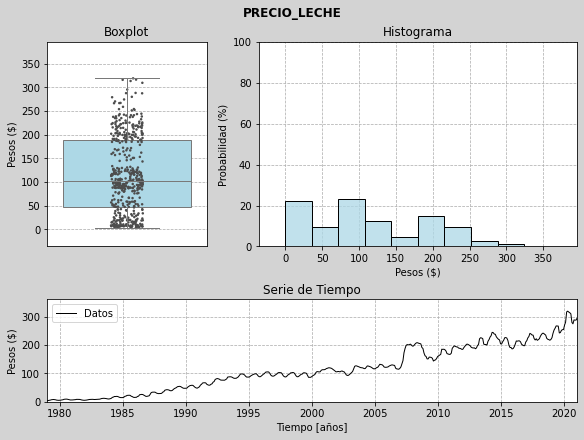

In [25]:
plot_distribution(df_merge, 'Precio_leche', "Pesos ($)", "PrecioLeche_distribucion.png", False)

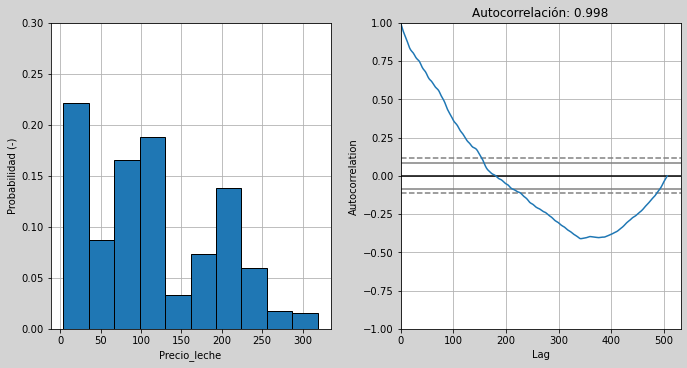

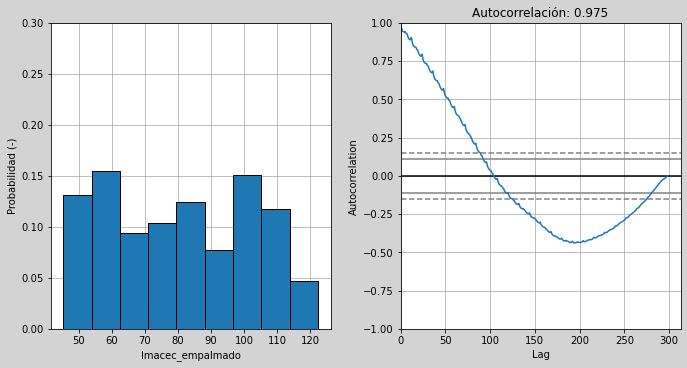

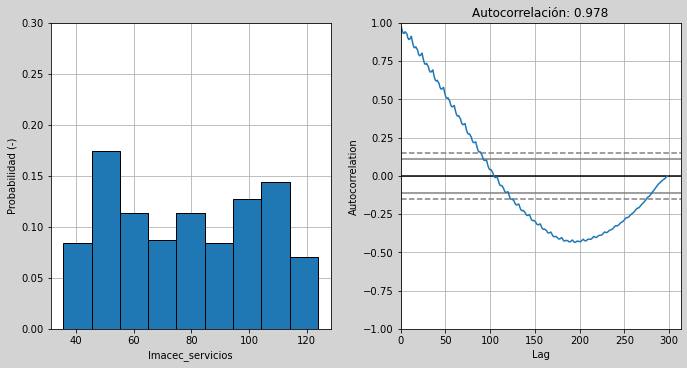

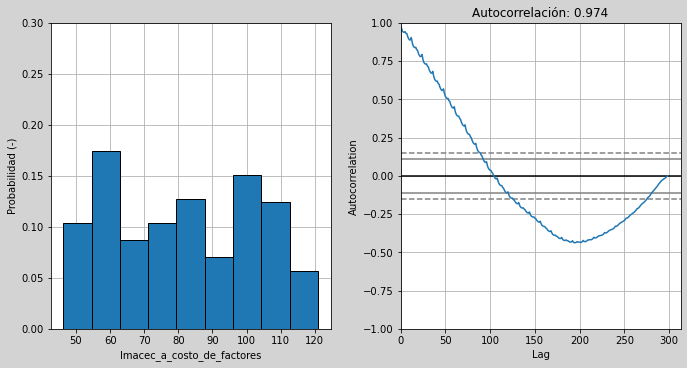

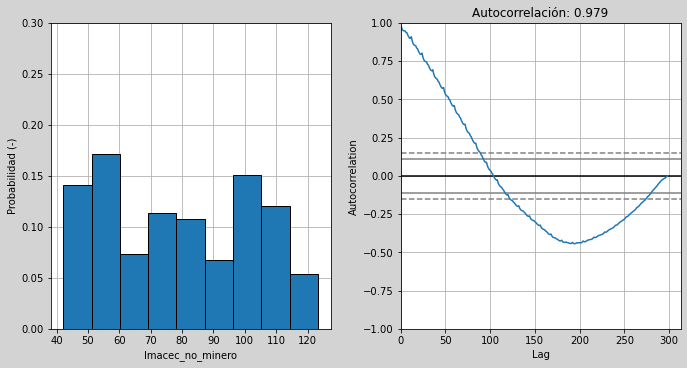

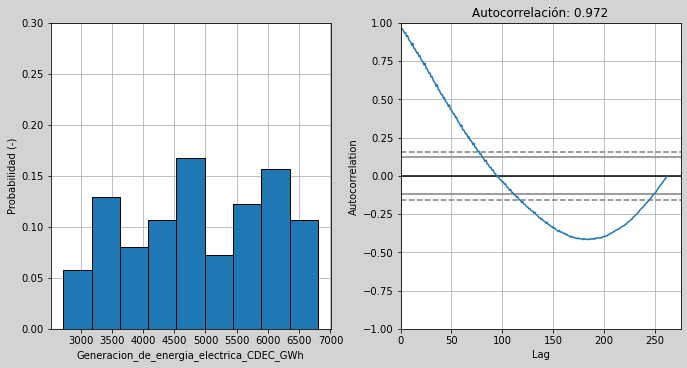

In [26]:
for col_name in columnas_relevantes:
    plot_variablesrelevantes(df_merge, col_name, 2, 1)

In [27]:
df_merge[columnas_relevantes].describe().T

,count,mean,std,min,25%,50%,75%,max
Precio_leche,506.000,114.445,79.000,3.850,48.163,102.250,189.175,318.880
Imacec_empalmado,298.000,80.897,21.265,45.352,60.152,80.326,100.671,122.348
Imacec_servicios,298.000,78.688,25.086,35.480,54.805,78.997,101.944,123.902
Imacec_a_costo_de_factores,298.000,81.565,20.667,46.265,61.626,81.185,100.570,120.908
Imacec_no_minero,298.000,79.046,23.119,42.157,56.022,78.314,100.524,123.293
Generacion_de_energia_electrica_CDEC_GWh,262.000,4909.356,1110.493,2724.397,4029.294,4817.860,5936.558,6798.200


In [36]:
# trimestre = {
#     12:"Ver", 1:"Ver",  2:"Ver",
#     3:"Oto",  4:"Oto",  5:"Oto",
#     6:"Inv",  7:"Inv",  8:"Inv",
#     9:"Pri", 10:"Pri", 11:"Pri"
#     }
trimestre = {
    12: 1,  1: 1,  2: 1,
    3:  2,  4: 2,  5: 2,
    6:  3,  7: 3,  8: 3,
    9:  4, 10: 4, 11: 4
    }
None if ("Mes" in df_merge.columns) else df_merge.insert(0, 'Mes', df_merge.index.month)
None if ("Año" in df_merge.columns) else df_merge.insert(0, 'Año', df_merge.index.year)
None if ("Trimestre" in df_merge.columns) else df_merge.insert(2, 'Trimestre', df_merge.Mes.map(trimestre))
columnas_relevantes = ["Mes", "Año", "Trimestre"] + columnas_relevantes.to_list()
df_merge[columnas_relevantes].head().T

date,1979-01-01,1979-02-01,1979-03-01,1979-04-01,1979-05-01
Mes,1.000,2.000,3.000,4.000,5.000
Año,1979.000,1979.000,1979.000,1979.000,1979.000
Trimestre,1.000,1.000,2.000,2.000,2.000
Precio_leche,3.850,4.580,5.180,6.060,7.250
Imacec_empalmado,NaN,NaN,NaN,NaN,NaN
Imacec_servicios,NaN,NaN,NaN,NaN,NaN
Imacec_a_costo_de_factores,NaN,NaN,NaN,NaN,NaN
Imacec_no_minero,NaN,NaN,NaN,NaN,NaN
Generacion_de_energia_electrica_CDEC_GWh,NaN,NaN,NaN,NaN,NaN


## 4.4 Conclusiones

# 5. Modelo
## 5.1 Predicción del valor

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display="diagram")

y = df_merge["Precio_leche"]
X = df_merge.drop("Precio_leche", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/10, random_state=42, shuffle=False)

In [40]:
categorical_columns_selector = selector(dtype_include=object)
numerical_columns_selector   = selector(dtype_include=[np.float32,np.float64,int])

categorical_columns = categorical_columns_selector(X)
numerical_columns   = numerical_columns_selector(X)
()
categorical_encoder = OneHotEncoder(handle_unknown='ignore')
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

preprocessing = ColumnTransformer(
    [('cat', categorical_encoder, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

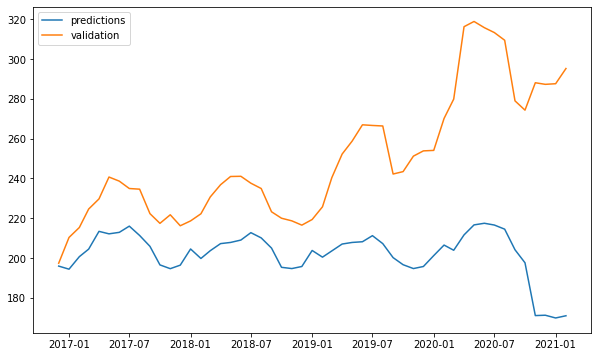

In [44]:
rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestRegressor(n_estimators=100, criterion="mae", random_state=42))
])
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
plt.figure(figsize=(10,6))
# plt.plot(y_train, label="train")
plt.plot(y_test.index, predictions, label="predictions")
plt.plot(y_test, label="validation")
plt.legend()

In [45]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0593 ± 0.0357,Mes
0 ± 0.0000,PIB_Servicios_de_vivienda
0 ± 0.0000,PIB_Celulosa
0 ± 0.0000,PIB_Refinacion_de_petroleo
0 ± 0.0000,PIB_Quimica
0 ± 0.0000,PIB_Minerales_no_metalicos_y_metalica_basica
0 ± 0.0000,PIB_Productos_metalicos
0 ± 0.0000,PIB_Electricidad
0 ± 0.0000,PIB_Construccion
0 ± 0.0000,PIB_Comercio
